In [1]:
import pandas as pd
import numpy as np

In [2]:
#1.PPI database
PPP_data = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\PPP_Projects_Total.csv")

In [3]:
#2.GDP per capita
GDP_per_capita = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP per Capita.csv")
#3.Tax as GDP
tax_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Tax as GDP.csv")
#4.GDP deflator(inflation rate)
GDP_deflator = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\GDP deflator.csv")
#5.life expectnacy
life_expectnacy = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Life expectnacy.csv")
#6.real effective change
real_effective_change = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Real effect change.csv")
#7.electric consumption
electric_consumption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Electric consumption.csv")
#8.domestic credit to private
domestic_credit_to_private = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Domestic credit to private.csv")
#9.Import as GDP
imports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Imports as GDP.csv")
#10.Export as GDP
exports_as_GDP = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Exports as GDP.csv")
#11.Control of corruption
control_of_corruption = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Control of corruption.csv")
#12.Government of effectiveness
government_effectiveness = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Government effectiveness.csv")
#13.Political stability
political_stability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Political Stability and Absence of Violence.csv")
#14.regulatory quality
regulatory_quality = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Regulatory quality.csv")
#15.Rule of law
rule_of_law = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Rule of law.csv")
#16.voice and accountability
voice_and_accountability = pd.read_csv(r"C:\PPP\Thesis\Paper3\Database\Voice and accountability.csv")

In [4]:
dataset = [GDP_per_capita, tax_as_GDP, GDP_deflator, life_expectnacy, real_effective_change,
           electric_consumption, domestic_credit_to_private, imports_as_GDP, exports_as_GDP, control_of_corruption,
           government_effectiveness, political_stability, regulatory_quality, rule_of_law, voice_and_accountability]

dataset_name = ['GDP_per_capita', 'tax_as_GDP', 'GDP_deflator', 'life_expectnacy', 'real_effective_change',
                'electric_consumption', 'domestic_credit_to_private', 'imports_as_GDP', 'exports_as_GDP', 'control_of_corruption',
                'government_effectiveness', 'political_stability', 'regulatory_quality', 'rule_of_law', 'voice_and_accountability']

In [5]:
def process_data(new_data):
    new_data.drop(columns=['Series Name', 'Series Code', 'Country Name'], inplace=True)
    new_data.set_index('Country Code', inplace=True)
    new_data.dropna(how='all', inplace=True)
    new_data.columns = [name.split(' ')[0] for name in list(new_data.columns)]

for data in dataset:
    process_data(data)

In [6]:
def meltdata(raw_data, column_name):
    new_data = pd.melt(raw_data.reset_index(), 
                       id_vars=['Country Code'], 
                       var_name=['Year'],
                       value_vars=raw_data.columns,
                       value_name=column_name)
    new_data.Year = new_data.Year.astype('int64', copy=False)
    return new_data

for i,name in zip(np.arange(len(dataset)), dataset_name):
    dataset[i] = meltdata(dataset[i], name).copy()
    dataset[i].rename(columns={'Country Code': 'countrycode', 'Year': 'IY'}, inplace=True)

In [7]:
for data in dataset:
    PPP_data= PPP_data.merge(data, left_on=['countrycode', 'IY'], right_on=['countrycode', 'IY'], how='left')

In [8]:
float_value = ['GDP_per_capita', 'tax_as_GDP', 'GDP_deflator', 'life_expectnacy', 'real_effective_change',
               'electric_consumption', 'domestic_credit_to_private', 'imports_as_GDP', 'exports_as_GDP', 'control_of_corruption',
               'government_effectiveness', 'political_stability', 'regulatory_quality', 'rule_of_law', 'voice_and_accountability']
nominal_value = ['Region', 'IDA', 'type', 'stype', 'sector',
                 'Segment', 'UP', 'PublicDisclosure', 'shareborder', 'region',
                 'PRS', 'Renewables', 'MLS', 'GGC','lendingtype']
ordinal_value = ['incomelevel']
float_value_2 = ['period', 'realphysicalassets', 'investment_real', 'GDP', 'population', 
                 'CPI2019', 'bordercountries', 'private', 'physical', 'period',
                 'investment', 'pcapacity']
PPP_data.drop(columns=['bid_crit', 'Description', 'incomelevelname', 'lendingtypename', 'regionname',
                       'adminregionname', 'BS', 'income', 'TIGS','ssector',
                       'PCO', 'FCY', 'country', 'adminregion'], inplace=True)

PPP_data.replace('..', np.nan, inplace=True)

PPP_data.replace({'status_n': {'Cancelled': 'fail', 'Distressed': 'fail', 'Active': 'success', 'Concluded': 'success'}}, inplace=True)

for float_column in float_value:
    PPP_data[float_column] = PPP_data[float_column].astype(float)

In [9]:
PPP_data.shape

(7096, 45)

In [443]:
#begin to resample
from sklearn.utils import resample
PPP_majority = PPP_data[PPP_data.status_n=='success']
PPP_minority = PPP_data[PPP_data.status_n=='fail']

PPP_minority_upsampled = resample(PPP_minority, 
                                 replace=True,
                                 n_samples=PPP_majority.shape[0],
                                 random_state=123)
upsampled_PPP = pd.concat([PPP_majority, PPP_minority_upsampled])

In [520]:
upsampled_PPP = PPP_data

In [521]:
#split the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

X = upsampled_PPP[upsampled_PPP.columns[upsampled_PPP.columns!='status_n']]
y = upsampled_PPP['status_n']
#income value is ordinal value
mapper = {'LIC': 1, 'HIC': 2, 'LMC': 3, 'UMC': 4, np.nan: 0}
X.loc[:, 'incomelevel'] = X.incomelevel.map(mapper)

y = LabelEncoder().fit_transform(y)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [522]:
X_train.GGC.unique()

array(['Federal', nan, 'Local', 'State/Provincial'], dtype=object)

In [523]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

In [529]:
y_test.sum()

1701

In [530]:
#first fillna for training dataset based on country, if some countries are non, then fill with the mode in current column, the same for test dataset.
def fillna_for_nominal(column_name, train_dataset, test_dataset):
    train_data = train_dataset.copy()
    test_data = test_dataset.copy()
    mode_in_train = train_data.groupby('countrycode')[column_name].agg(pd.Series.mode).to_frame()
    for index, row in mode_in_train.iterrows():
        if type(row[column_name]) == np.ndarray:
            mode_in_train.loc[index, column_name] = train_data[column_name].mode()[0]
    countrycode_in_train = train_data.countrycode.unique()
    countrycode_in_test = train_data.countrycode.unique()
    
    for country in countrycode_in_train:
        train_data.loc[train_data.countrycode==country, column_name] = train_data.loc[train_data.countrycode==country, column_name].fillna(mode_in_train.loc[country, column_name])

    for country in countrycode_in_test:
        if country in countrycode_in_train:
            test_data.loc[test_data.countrycode==country, column_name] = test_data.loc[test_data.countrycode==country, column_name].fillna(mode_in_train.loc[country, column_name])
    test_data.loc[test_data[column_name].isnull(), column_name] = test_data.loc[test_data[column_name].isnull(), column_name].fillna(test_data[column_name].mode()[0])
    return train_data, test_data

In [531]:
X_new_train = X_train.copy()
X_new_test = X_test.copy()
nominal_list = ['GGC', 'PRS', 'lendingtype']
for name in nominal_list:
    X_new_train, X_new_test = fillna_for_nominal(name, X_new_train, X_new_test)

In [532]:
def fillna_for_float(column_name, train_dataset, test_dataset):
    train_data = train_dataset.copy()
    test_data = test_dataset.copy()
    mean_in_train = train_data.groupby('countrycode')[column_name].agg(pd.Series.mean).to_frame()
    for index, row in mean_in_train.iterrows():
        mean_in_train.loc[index, column_name] = train_data[column_name].mean()
    countrycode_in_train = train_data.countrycode.unique()
    countrycode_in_test = train_data.countrycode.unique()
    
    for country in countrycode_in_train:
        train_data.loc[train_data.countrycode==country, column_name] = train_data.loc[train_data.countrycode==country, column_name].fillna(mean_in_train.loc[country, column_name])

    for country in countrycode_in_test:
        if country in countrycode_in_train:
            test_data.loc[test_data.countrycode==country, column_name] = test_data.loc[test_data.countrycode==country, column_name].fillna(mean_in_train.loc[country, column_name])
    test_data.loc[test_data[column_name].isnull(), column_name] = test_data.loc[test_data[column_name].isnull(), column_name].fillna(test_data[column_name].mean())
    return train_data, test_data

In [533]:
for name in float_value:
    X_new_train, X_new_test = fillna_for_float(name, X_new_train, X_new_test)

In [534]:
for name in float_value_2:
    X_new_train, X_new_test = fillna_for_float(name, X_new_train, X_new_test)

In [474]:
combine_dataset.shape

(13640, 44)

In [535]:
train_objs_num = len(X_new_train)
combine_dataset = pd.concat(objs=[X_new_train, X_new_test], axis=0)
dataset_preprocessed = pd.get_dummies(combine_dataset, columns=nominal_value)
X_new_train = dataset_preprocessed[:train_objs_num]
X_new_test = dataset_preprocessed[train_objs_num:]

In [536]:
X_new_train.drop(columns=['IY', 'countrycode'], inplace=True)
X_new_test.drop(columns=['IY', 'countrycode'], inplace=True)

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [487]:
X_new_test, X_new_validation, y_test, y_validation = train_test_split(X_new_test, y_test, test_size=0.25, random_state=123)


In [537]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_new_train = scaler.fit_transform(X_new_train.values)

X_new_test = scaler.transform(X_new_test.values)

In [538]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=1)
clf.fit(X_new_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [539]:
X_new_test

array([[ 2.79565829e+00,  4.30749113e-01, -1.64468318e-01, ...,
        -1.72623178e-01,  3.72369733e+00, -3.06656145e-02],
       [ 0.00000000e+00,  4.30749113e-01, -3.89177131e-01, ...,
         5.79296483e+00, -2.68550291e-01, -3.06656145e-02],
       [-1.71254129e+00, -8.56301633e-16, -2.75570547e-01, ...,
        -1.72623178e-01,  3.72369733e+00, -3.06656145e-02],
       ...,
       [ 5.41558501e-01,  4.30749113e-01, -7.76487368e-16, ...,
        -1.72623178e-01, -2.68550291e-01, -3.06656145e-02],
       [ 0.00000000e+00,  4.30749113e-01, -3.59580225e-01, ...,
        -1.72623178e-01, -2.68550291e-01, -3.06656145e-02],
       [ 5.41558501e-01,  4.30749113e-01, -7.76487368e-16, ...,
        -1.72623178e-01, -2.68550291e-01, -3.06656145e-02]])

In [478]:
import matplotlib.pyplot as plt
def plot_roc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'k', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.axis('square')
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return (fpr, tpr, thresholds)

In [540]:
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn import metrics

pred = cross_val_predict(clf,
                        X_new_test,
                        y_test,
                        method='predict_proba',
                        cv=5)

(array([0.        , 0.04109589, 0.04109589, 0.06849315, 0.06849315,
        0.06849315, 0.09589041, 0.09589041, 0.09589041, 0.09589041,
        0.10958904, 0.10958904, 0.10958904, 0.10958904, 0.12328767,
        0.12328767, 0.15068493, 0.15068493, 0.16438356, 0.16438356,
        0.20547945, 0.23287671, 0.23287671, 0.23287671, 0.24657534,
        0.24657534, 0.24657534, 0.2739726 , 0.2739726 , 0.28767123,
        0.31506849, 0.31506849, 0.31506849, 0.32876712, 0.34246575,
        0.36986301, 0.43835616, 0.43835616, 0.43835616, 0.43835616,
        0.43835616, 0.43835616, 0.45205479, 0.45205479, 0.46575342,
        0.46575342, 0.49315068, 0.50684932, 0.52054795, 0.53424658,
        0.53424658, 0.64383562, 0.64383562, 0.64383562, 0.65753425,
        0.65753425, 0.67123288, 0.67123288, 0.68493151, 0.68493151,
        0.68493151, 0.68493151, 0.69863014, 0.71232877, 0.7260274 ,
        0.73972603, 0.73972603, 0.73972603, 0.76712329, 0.78082192,
        0.79452055, 0.80821918, 0.80821918, 0.80

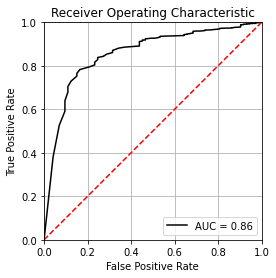

In [541]:
plot_roc(y_test, pred[:,1])

In [492]:
import seaborn as sns
def plot_cm(labels, predictions, p=0.8):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

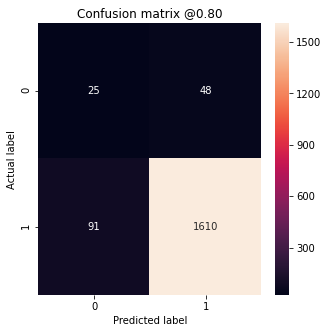

In [542]:
plot_cm(y_test, pred[:, 1])

In [544]:
y_test.shape

(1774,)

In [495]:
#feature importance
fi = pd.DataFrame({'feature': list(X_new_train.columns),
                   'importance': clf.feature_importances_}).\
                    sort_values('importance', ascending = False)

In [497]:
fi.head(20)

,feature,importance
9,CPI2019,0.085694
7,GDP,0.049078
8,population,0.044292
10,investment_real,0.040894
22,government_effectiveness,0.035426
3,investment,0.034151
11,realphysicalassets,0.032277
4,pcapacity,0.032243
2,physical,0.031596
100,PRS_Other,0.031089


In [545]:
from sklearn.linear_model import LogisticRegression
clf_1 = LogisticRegression()

In [546]:
clf_1.fit(X_new_train, y_train)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [547]:
pred_1 = cross_val_predict(clf_1,
                          X_new_test,
                          y_test,
                          method='predict_proba',
                          cv=5)

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(array([0.        , 0.        , 0.        , 0.01369863, 0.01369863,
        0.02739726, 0.02739726, 0.04109589, 0.04109589, 0.05479452,
        0.05479452, 0.06849315, 0.06849315, 0.08219178, 0.08219178,
        0.09589041, 0.09589041, 0.10958904, 0.10958904, 0.12328767,
        0.12328767, 0.1369863 , 0.1369863 , 0.15068493, 0.15068493,
        0.16438356, 0.16438356, 0.17808219, 0.17808219, 0.19178082,
        0.19178082, 0.20547945, 0.20547945, 0.21917808, 0.21917808,
        0.23287671, 0.23287671, 0.24657534, 0.24657534, 0.26027397,
        0.26027397, 0.2739726 , 0.2739726 , 0.28767123, 0.28767123,
        0.30136986, 0.30136986, 0.31506849, 0.31506849, 0.32876712,
        0.32876712, 0.34246575, 0.34246575, 0.35616438, 0.35616438,
        0.36986301, 0.36986301, 0.38356164, 0.38356164, 0.39726027,
        0.39726027, 0.4109589 , 0.4109589 , 0.42465753, 0.42465753,
        0.43835616, 0.43835616, 0.46575342, 0.46575342, 0.47945205,
        0.47945205, 0.49315068, 0.49315068, 0.50

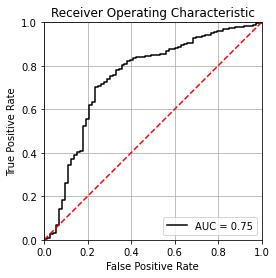

In [548]:
plot_roc(y_test, pred_1[:,1])

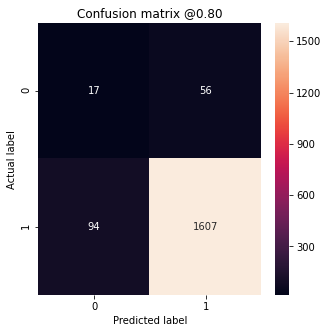

In [549]:
plot_cm(y_test, pred_1[:, 1])